# Calibrated Adversarial Learning (Part 1)
## A visual exploration

In this notebook we visualise the mechanism of calibrated adversarial learning presented in the paper "Calibrated Adversarial Refinement for Multimodal Semantic Segmentation" by Kassapis et al.

In [1]:
%matplotlib inline
import numpy as np
import torch
from torch import optim

import matplotlib.pyplot as plt
import tqdm.notebook as tqdm

from utils import data, networks

In [2]:
SEED = 999

torch.manual_seed(SEED)
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(device)

cpu


## Data generation function

The data generation function $y = f(x, b, \epsilon)$ is defined as:

$$
y =  
\begin{cases}
  0.5 - b + \epsilon, & x \in [0, 0.4) \\
  (-1)^b(-1.25x + 1) + \epsilon, & x \in [0.4, 0.8) \\
  \epsilon, & x \in [0.8, 1]
\end{cases}
$$

using the random variables $b \sim \mathrm{Bernoulli}(\pi)$ and $\epsilon \sim \mathcal{N}(0, \sigma)$. Here $\sigma$ is the amount of noise in $y$ and $\pi$ is the probablity of chosing the upper mode $(b=0)$ and $(1-\pi)$---the lower mode $(b=1)$. 

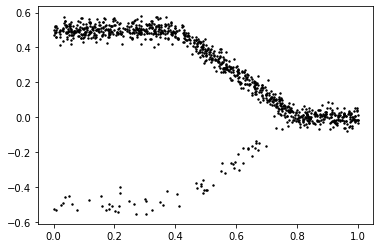

In [3]:
data_gen = data.Bifurcation(pi=0.9, sigma=0.03)
xs, ys = next(data_gen.produce(1000, seed=SEED))
plt.scatter(xs, ys, s=2.0, c="black")

## Calibration network pretraining

In the following we train an MLP to regress the data from above. Since we use a Gaussian likelihood the network will not be able to fit the data faithfully. It will however learn the mean of the two modes for every $x$ and thereby set a _calibration target_ for the adversarial network.

In [4]:
net_cal = networks.MLP([64, 64, 64, 64]).to(device)
opt_cal = optim.Adam(net_cal.parameters(), lr=1e-4)

The training step function for the calibration network is simply minimising the negative log-likelihood. Due to the simplicity of the problem a batch size of 1000 and a training duration of 1500 iterations are enough.

In [5]:
def run_step_cal(xs_t, ys_t, opt_cal, net_cal):
    opt_cal.zero_grad()
    loss = -torch.mean(net_cal.ll(xs_t, ys_t))
    loss.backward()
    opt_cal.step()
    return loss.detach().cpu().numpy()

def train_cal(producer, net_cal, opt_cal):
    pbar = tqdm.tqdm(range(1500))
    data = producer.produce(1000, seed=SEED)
    for i in pbar:
        xs, ys = next(data)
        xs_t = torch.as_tensor(xs).to(device)
        ys_t = torch.as_tensor(ys).to(device)
        loss = run_step_cal(xs_t, ys_t, opt_cal, net_cal)
        pbar.set_description_str(f"loss: {loss:4.2f}, ")

In [6]:
train_cal(data_gen, net_cal, opt_cal)

We now plot the data (black dots), the calibration network predictions (orange red line) and the data mean for each $x$ (green dotted line). We expect that the calibration network will fit the mean perfectly given the abundance of data and simplicity of the problem.

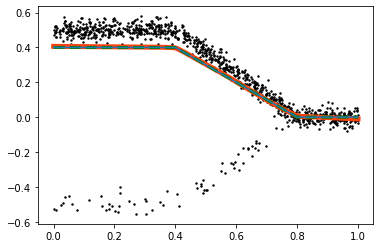

In [7]:
xs, ys = next(data_gen.produce(1000, SEED))
xs_t, ys_t = torch.as_tensor(xs).to(device), torch.as_tensor(ys).to(device)
ys_cal = net_cal(xs_t).detach()
sort_idx = np.argsort(xs)
plt.scatter(xs, ys, s=2.0, c="black")
plt.plot(xs[sort_idx], ys_cal.cpu().numpy().squeeze()[sort_idx],
         "-", linewidth=5.0, c="xkcd:orangered")
plt.plot(xs[sort_idx], data_gen.mean(xs[sort_idx]),
         "--", linewidth=3.0, color="green")
plt.plot(xs[sort_idx], data_gen.mean(xs[sort_idx]), )

## Conditional adversarial networks

Next, we train a conditional generator network to produce samples $\hat{y}$ for a given $x$ that faithfully match the ground truth distribution with the help of an auxiliary discriminator network. In the context of the paper, the generator is called a _refinement_ network as it receives the preprocessed input from the calibration network. 

We use architectures similar to the one of the calibration network.

In [8]:
net_ref = networks.Generator(
    input_dim=2, n_hidden=[64, 64, 64, 64], noise_dim=1
).to(device)
opt_ref = optim.Adam(net_ref.parameters(), lr=1e-4)
net_dis = networks.Discriminator(
    input_dim=2, n_hidden=[64, 64, 64, 64]
).to(device)
opt_dis = optim.Adam(net_dis.parameters(), lr=1e-4)

Define the training step for the discriminator and the refinement network and a utility function to compute the quality of the fit in terms of the log-likelihood.

In [9]:
def run_step_dis(xs, ys, ys_ref, net_dis, opt_dis):
    opt_dis.zero_grad()
    loss_dis = -torch.mean(
        torch.sum(net_dis.ll([xs, ys], torch.ones(len(ys)).to(device)), -1)
        + torch.sum(net_dis.ll([xs, ys_ref], torch.zeros(len(ys_ref)).to(device)), -1)
    )
    loss_dis.backward()
    opt_dis.step()
    return loss_dis.detach().cpu().numpy()

def run_step_ref(xs, ys_cal, net_ref, net_dis, opt_ref, n_samples=1, lambda_cal=0.0):
    opt_ref.zero_grad()
    ys_ref = net_ref([xs, ys_cal], n_samples=n_samples)
    xs_repeated = torch.repeat_interleave(
        xs, repeats=ys_ref.shape[0] // xs.shape[0], dim=0
    )
    total_loss = 0
    losses_per_type = []
    if lambda_cal > 0:
        # compute the average: E_eps[G(F(x), eps)] which will be matched
        # to the calibration target `ys_cal`
        ys_ref_mean = torch.mean(ys_ref.view(-1, n_samples), dim=1, keepdim=True)
        # compute the calibration loss as the KL-divergence between 
        # two Gaussians with fixed scales of 1
        loss_kl = 0.5 * torch.mean((ys_ref_mean - ys_cal) ** 2)
        total_loss += lambda_cal * loss_kl
        losses_per_type.append(loss_kl.detach().cpu().numpy())
    ll_dis = net_dis.ll([xs_repeated, ys_ref], torch.ones(len(ys_ref)).to(device))
    loss_dis = -torch.mean(torch.sum(ll_dis, -1))
    total_loss += loss_dis
    losses_per_type.append(loss_dis.detach().cpu().numpy())
    total_loss.backward()
    opt_ref.step()
    return np.array(losses_per_type)

Train the two adversarial networks for 5k iterations with a batch size of 100 and 10 samples for the calibration loss computation.

In [10]:
def train_dis_ref(producer, net_cal, net_ref, opt_ref, net_dis, opt_dis, lambda_cal):
    pbar = tqdm.tqdm(range(5000))
    data = producer.produce(100, seed=SEED)
    for i in pbar:
        xs, ys = next(data)
        xs_t = torch.as_tensor(xs.reshape(-1, 1)).to(device)
        ys_t = torch.as_tensor(ys.reshape(-1, 1)).to(device)
        with torch.no_grad():
            ys_cal = net_cal(xs_t).detach()
            ys_ref = net_ref([xs_t, ys_cal]).detach()
        loss_dis = run_step_dis(xs_t, ys_t, ys_ref, net_dis, opt_dis)
        n_samples = 10 if lambda_cal > 0 else 1
        loss_ref = run_step_ref(
            xs_t, ys_cal, net_ref, net_dis, opt_ref, n_samples, lambda_cal
        )
        pbar.set_description_str(f"dis: {loss_dis:4.2f}, ref: {np.sum(loss_ref):4.2f}")

In [11]:
train_dis_ref(
    data_gen, net_cal, net_ref, opt_ref, net_dis, opt_dis, lambda_cal=1.0
)

Some more plotting utilities to visualise the disciriminator decision boundary, the predictions of the refinement network and the calibration quality.

In [12]:
def compute_calibration(xs, net_ref, net_cal):
    n_samples = 1000
    xs_t = torch.as_tensor(xs.astype(np.float32)).to(device)
    with torch.no_grad():
        ys_cal = net_cal(xs_t).detach()
        ys_ref = net_ref([xs_t, ys_cal], n_samples=n_samples).detach().cpu().numpy()
    bias_ref = np.mean(ys_ref.reshape(len(xs), n_samples), axis=1)
    return np.asarray(bias_ref)

def add_data_hist(ax, producer):
    data = producer.produce(1000000, seed=SEED)
    xs, ys = next(data)
    ax.hist2d(xs, ys, bins=200, cmap="gray_r", alpha=1, zorder=0)

def check_nets(producer, net_cal, net_ref, net_dis):
    xs, ys = next(producer.produce(200, seed=SEED))
    xs_t, ys_t = torch.as_tensor(xs).to(device), torch.as_tensor(ys).to(device)
    ys_cal = net_cal(xs_t).detach()
    ys_ref = net_ref([xs_t, ys_cal], n_samples=1).detach().cpu().numpy()
    lin_domain_xs = np.linspace(0., 1, 100) 
    bias_ref = compute_calibration(lin_domain_xs, net_ref, net_cal)
    grid_size = 1000
    domain_xs, domain_ys = np.meshgrid(
        np.linspace(0., 1., grid_size, dtype=np.float32),
        np.linspace(-0.6, 0.6, grid_size, dtype=np.float32)
    )
    ys_dis = net_dis(
        [torch.as_tensor(domain_xs).reshape(-1, 1).to(device),
         torch.as_tensor(domain_ys).reshape(-1, 1).to(device)],
        as_probs=True
    )
    ys_dis = ys_dis.detach().cpu().numpy().reshape(grid_size, grid_size)
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.imshow(ys_dis, origin="lower left", interpolation="none", 
              cmap="coolwarm", alpha=0.15, extent=[0, 1, -0.6, 0.6], aspect=1/1.2)
    add_data_hist(ax, producer)
    sort_inx = np.argsort(xs)
    ax.plot(xs[sort_inx], ys_cal.cpu().numpy().squeeze()[sort_inx], "-",
            linewidth=5.0, c="xkcd:orangered", label=r"$F_{\theta}(x)$")
    ax.scatter(xs_t.cpu().numpy(), ys_ref.squeeze(), s=30.0, c="lightskyblue", 
               label=r"$G_\phi(F_{\theta}(x),\epsilon)$")
    ax.plot(lin_domain_xs, bias_ref, "-", linewidth=3.0, c="darkblue", 
           label=r"$\overline{G}_{\phi}(F_{\theta}(x))$", alpha=1)
    ax.legend(loc='lower right')
    ax.set_ylabel("y")
    ax.set_xlabel("x")
    ax.set_ylim([-0.6, 0.6])

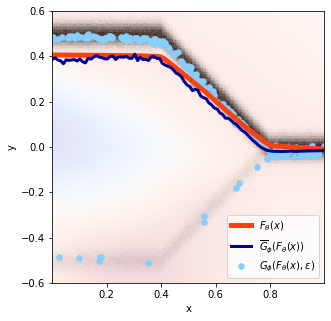

In [17]:
check_nets(data_gen, net_cal, net_ref, net_dis)

Finally, we train a baseline to show the tendency of mode collapse.

In [19]:
net_ref2 = networks.Generator(
    input_dim=2, n_hidden=[64, 64, 64, 64], noise_dim=1
).to(device)
opt_ref2 = optim.Adam(net_ref2.parameters(), lr=1e-4)
net_dis2 = networks.Discriminator(
    input_dim=2, n_hidden=[64, 64, 64, 64]
).to(device)
opt_dis2 = optim.Adam(net_dis2.parameters(), lr=1e-4)
train_dis_ref(
    data_gen, net_cal, net_ref2, opt_ref2, net_dis2, opt_dis2, lambda_cal=0
)

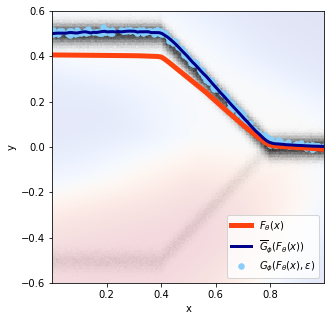

In [20]:
check_nets(data_gen, net_cal, net_ref2, net_dis2)

Note that the baseline model might work by chance. Retraining the networks multiple times will show the robustness of the calibrated adversarial network against the baseline. We explore this further in the `part_2.ipynb` notebook.